# CH3.CNN(VGG)
VGG를 직접 구현해 CIFAR10데이터에 적용 해본다.

이 실습을 통해 기본적인 Pytorch의 학습 방식과 VGG 모델의 구조를 직접 구축해볼 수 있다.

### Content
1. 필요한 패키지 불러오기 및 parameter 구성하기
2. CIFAR10 데이터 가져오기
3. Trainloader 이미지 살펴보기
4. AlexNet 모델 정의
5. 모델 학습
6. 모델 검증

### Reference
* https://arxiv.org/abs/1409.1556
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://github.com/Lornatang/VGG-PyTorch

## 1. 필요한 패키지 불러오기 및 parameter 구성하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time, datetime


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 32,
          'worker'      : 2,
          'epochs'      : 5,
          'momentum'    : 0.9,
          'lr_decay'    : 0.0005,
          'SGD_lr'      : 0.01,
          'Adam_lr'     : 0.001,
          }

cuda


## 2. CIFAR10데이터 가져오기
CIFAR10 데이터는 총 60,000장(클래스당 6,000장)의 이미지를 가지고 있으며 이중 50,000장은 train image, 10,000장은 test image로 사용된다.
(https://www.cs.toronto.edu/~kriz/cifar.html)
![CIFAR-10](https://user-images.githubusercontent.com/79437139/128126531-b9c51860-cc9e-4486-b83b-d892588a7f17.jpg)


일반적으로 이미지나 텍스트, 오디오, 비디오 데이터를 다룰 때는 표준 Python패키지를 이용해 Numpy배열로 불러온다. Pytorch에서는 그 배열을 `torch.*Tensor`로 변환한다.
* 이미지: Pillow, OpenCV, Matplotlib
* 오디오: SciPy, LibROSA
* 텍스트: 일반 Python, Cython, NLTK, SpaCy

Pytorch에서는 영상분야를 위한 `torchvision` 패키지가 있는데 여기서 Imagenet, CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 data loader, 즉 `torchvision.datasets`과 이미지용 데이터변환기(data transformer) 즉, `torch.utils.data.DataLoader`가 포함되어 있다.

여기서는 `torchvision`을 사용하여 CIFAR10의 Train/Test 데이터셋을 불러오고 정규화를 적용해준다.


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# CIFAR10 data download 
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = train_transforms)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = test_transforms)
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")

# DatsLoader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])
testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

Files already downloaded and verified
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. trainloader 이미지 살펴보기

CIFAR10데이터 가져오기에서 만든 trainloader에 이미지가 어떻게 저장되어있는지 이미지와 라벨을 같이 확인해본다.

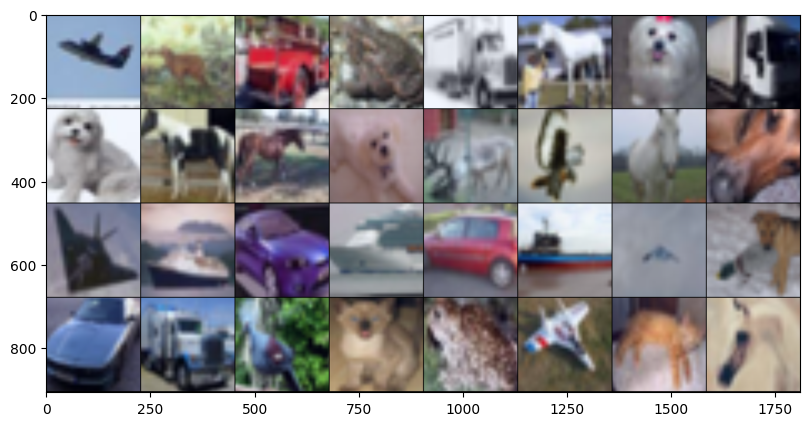

1: airplane	2: deer  	3: truck  	4: frog  	5: truck  	6: horse  	7: dog  	8: truck
9: dog  	10: horse  	11: horse  	12: dog  	13: deer  	14: bird  	15: horse  	16: dog
17: airplane	18: ship  	19: automobile	20: ship  	21: automobile	22: ship  	23: airplane	24: dog
25: automobile	26: truck  	27: bird  	28: cat  	29: frog  	30: airplane	31: cat  	32: horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2,0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

## 4. VGG 모델 정의
VGG 모델을 직접 구축해보자
<div align="left">
        <img src="https://drive.google.com/uc?id=1K59PWcO6f6164jNrczCn3QwZ4uKwn8Hp" width="50%" alt=""/>
</div>

In [ ]:
from typing import cast, Dict, List, Union

import torch
from torch import Tensor
from torch import nn

__all__ = [
    "VGG",
    "vgg11", "vgg13", "vgg16", "vgg19",
    "vgg11_bn", "vgg13_bn", "vgg16_bn", "vgg19_bn",
]

vgg_cfgs: Dict[str, List[Union[str, int]]] = {
    "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "vgg19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


def _make_layers(vgg_cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: nn.Sequential[nn.Module] = nn.Sequential()
    in_channels = 3
    for v in vgg_cfg:
        if v == "M":
            layers.append(nn.MaxPool2d((2, 2), (2, 2)))
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, (3, 3), (1, 1), (1, 1))
            if batch_norm:
                layers.append(conv2d)
                layers.append(nn.BatchNorm2d(v))
                layers.append(nn.ReLU(True))
            else:
                layers.append(conv2d)
                layers.append(nn.ReLU(True))
            in_channels = v

    return layers


class VGG(nn.Module):
    def __init__(self, vgg_cfg: List[Union[str, int]], batch_norm: bool = False, num_classes: int = 1000) -> None:
        super(VGG, self).__init__()
        self.features = _make_layers(vgg_cfg, batch_norm)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        # Initialize neural network weights
        self._initialize_weights()

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)


def vgg11(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], False, **kwargs)

    return model


def vgg13(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], False, **kwargs)

    return model


def vgg16(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], False, **kwargs)

    return model


def vgg19(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], False, **kwargs)

    return model


def vgg11_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], True, **kwargs)

    return model


def vgg13_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], True, **kwargs)

    return model


def vgg16_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], True, **kwargs)

    return model


def vgg19_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], True, **kwargs)

    return model

In [ ]:
# 모델 확인
model = vgg11()
model = model.to(device)
summary(model, (3,224,224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

## 5. 모델 학습

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = config['Adam_lr'])
optimizer = optim.SGD(params=model.parameters(), lr = config['SGD_lr'], momentum= config['momentum'], weight_decay=config['lr_decay'])

In [ ]:
for epoch in range(config['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #Time
        end_time = time.time()
        duration = str(datetime.timedelta(seconds=time.time() - start_time)).split('.')[0]
       
    print('Epoch: {}/{}, train_loss: {:.4f}, time:{}'.format(epoch + 1, config['epochs'], running_loss / len(trainset), duration))

print('Finished Training of VGG')

Epoch: 1/5, train_loss: 0.0589, time:0:06:22
Epoch: 2/5, train_loss: 0.0349, time:0:06:24
Epoch: 3/5, train_loss: 0.0270, time:0:06:24
Epoch: 4/5, train_loss: 0.0223, time:0:06:24
Epoch: 5/5, train_loss: 0.0192, time:0:06:25
Finished Training of VGG


## 6. 모델 검증

In [ ]:
# Testloader 전체의 정확도
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 74.68 %


In [ ]:
# 각 class 별 정확도
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes_name[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 87 %
Accuracy of automobile : 91 %
Accuracy of  bird : 57 %
Accuracy of   cat : 59 %
Accuracy of  deer : 75 %
Accuracy of   dog : 68 %
Accuracy of  frog : 71 %
Accuracy of horse : 71 %
Accuracy of  ship : 84 %
Accuracy of truck : 85 %
